In [11]:
import pandas as pd
import statsmodels.stats.power as smp
import math
import numpy as np

In [3]:
df = pd.read_csv('/home/nic/Загрузки/cookie_cats.csv')

In [5]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


Проверка на пропуски данных

In [6]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [7]:
df['userid'].nunique()

90189

Количество уникальных id user = количеству строк, делаем вывод что данные не нуждаются в чистке

Для анализа возможны три метрики: возвращение игрока через день(retention_1), возвращение игрока на 7 день(retention_7) и количество проведенных игр одним игроком(sum_gamerounds). А/В тестирование проводилось для двух версий (gate_30 и gate_40). Разобьем данные на эти группы:

In [8]:
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"mean"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,52.456264
gate_40,45489,0.442283,0.182000,51.298776


Из таблицы видно, что группы разбиты относительно равномерно, имеют различия по всем метрикам
Проведем исследование для метрик возвращение игрока через день(retention_1) и возвращение игрока на 7 день(retention_7)

In [16]:
# Расчет величины эффекта от версии на метрику возвращение игрока через день(retention_1)
alpha = 0.05
power = 0.8
n = 44700             
p_x = 0.448188           
p_y = 0.442283
# effect_size

h = 2 * math.asin(np.sqrt(p_x)) - 2 * math.asin(np.sqrt(p_y))
h

0.011881556187072428

In [15]:
power = smp.zt_ind_solve_power(effect_size=h, nobs1=n, alpha=alpha, alternative='two-sided')
power

0.42722514573483844

In [17]:
# Расчет величины эффекта от версии на метрику возвращение игрока через день(retention_7)
alpha = 0.05
power = 0.8
n = 44700             
p_x = 0.190201           
p_y = 0.182000
# effect_size

h = 2 * math.asin(np.sqrt(p_x)) - 2 * math.asin(np.sqrt(p_y))
h

0.021073242820461302

In [18]:
power = smp.zt_ind_solve_power(effect_size=h, nobs1=n, alpha=alpha, alternative='two-sided')
power

0.8830689494554991

Для сравнения метрики возвращение игрока через день(retention_1) нам не хватает количества наблюдений что бы сделать правильный вывод (разница в 1.2% требует количество наблюдений увеличить в 2 раза). Метрика  возвращение игрока через 7 дней(retention_7) обладает необходимой мошностью теста.

In [20]:

def interval_95 (p1, p2, n1, n2):
    return(p2 - p1 - 1.96 * (p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)**0.5, 
           p2 - p1 + 1.96 * (p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)**0.5)

In [21]:
retention_7 = interval_95(0.190201, 0.182000, 44700, 45489)
retention_7

(-0.01328134543003797, -0.003120654569962058)

Между группами gate_30 и gate_40 есть статистически значимая разница с вероятностью 95% (0 не принадлежит интервалу retention_7)

# Для работы с метрикой sum_gamerounds:

In [22]:
df_gate_30 = df[df['version']== 'gate_30']
df_gate_30.describe()

,userid,sum_gamerounds
count,4.470000e+04,44700.000000
mean,4.987564e+06,52.456264
std,2.881026e+06,256.716423
min,1.160000e+02,0.000000
25%,2.505469e+06,5.000000
50%,4.983631e+06,17.000000
75%,7.481497e+06,50.000000
max,9.999710e+06,49854.000000


In [23]:
df_gate_40 = df[df['version']== 'gate_40']
df_gate_40.describe()

,userid,sum_gamerounds
count,4.548900e+04,45489.000000
mean,5.009073e+06,51.298776
std,2.885496e+06,103.294416
min,3.770000e+02,0.000000
25%,2.517171e+06,5.000000
50%,5.007329e+06,16.000000
75%,7.510762e+06,52.000000
max,9.999861e+06,2640.000000


Разница в среднем количестве игровых раундов между  gate_30 и gate_40:

In [24]:
(52.456264 - 51.298776)/ 52.456264 *100

2.206577273593104

Отслеживание изменений в 2.2 % обладают необходимой мощностью на наших данных.
Проверим данные на нормальное распредаление

In [25]:
x = np.array(df_gate_30['sum_gamerounds'])
y = np.array(df_gate_40['sum_gamerounds'])

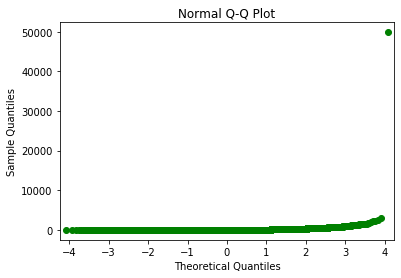

In [26]:
import statsmodels.api as sm
from matplotlib import pyplot as plt

fig = sm.qqplot(x, color='green')
plt.title('Normal Q-Q Plot')
plt.show;

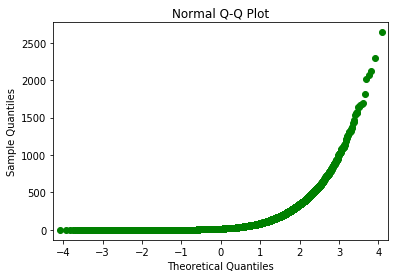

In [27]:
import statsmodels.api as sm
from matplotlib import pyplot as plt

fig = sm.qqplot(y, color='green')
plt.title('Normal Q-Q Plot')
plt.show;

По этим выборкам данные распределения отличаются от нормального.

для анализа данных не имеющих нормального распределения воспользуемся фоимулой Манни Уитни для пычисление pvalue

In [28]:
from scipy.stats import mannwhitneyu
print(mannwhitneyu(x, y))

MannwhitneyuResult(statistic=1009027049.5, pvalue=0.025104403860221253)


поскольку pvalue=0.025 < 0.05, то разница между группами статистически значима. 

## Вывод: на основании метрики retention_7 и sum_gamerounds можно рекомендовать версию gate_30 поскольку при этой версии статистически выше с достоверностью в 95 % выше возврат игроков на 7 день(2.1 %) и среднее количество сыгранных раундов(2.2 %)